In [1]:


import os

data_path = r"D:\project1\pythonProject\ML-LIME-Power\dataset"

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\project1\pythonProject\ML-LIME-Power\dataset\energy_dataset.csv.zip
D:\project1\pythonProject\ML-LIME-Power\dataset\weather_features.csv.zip


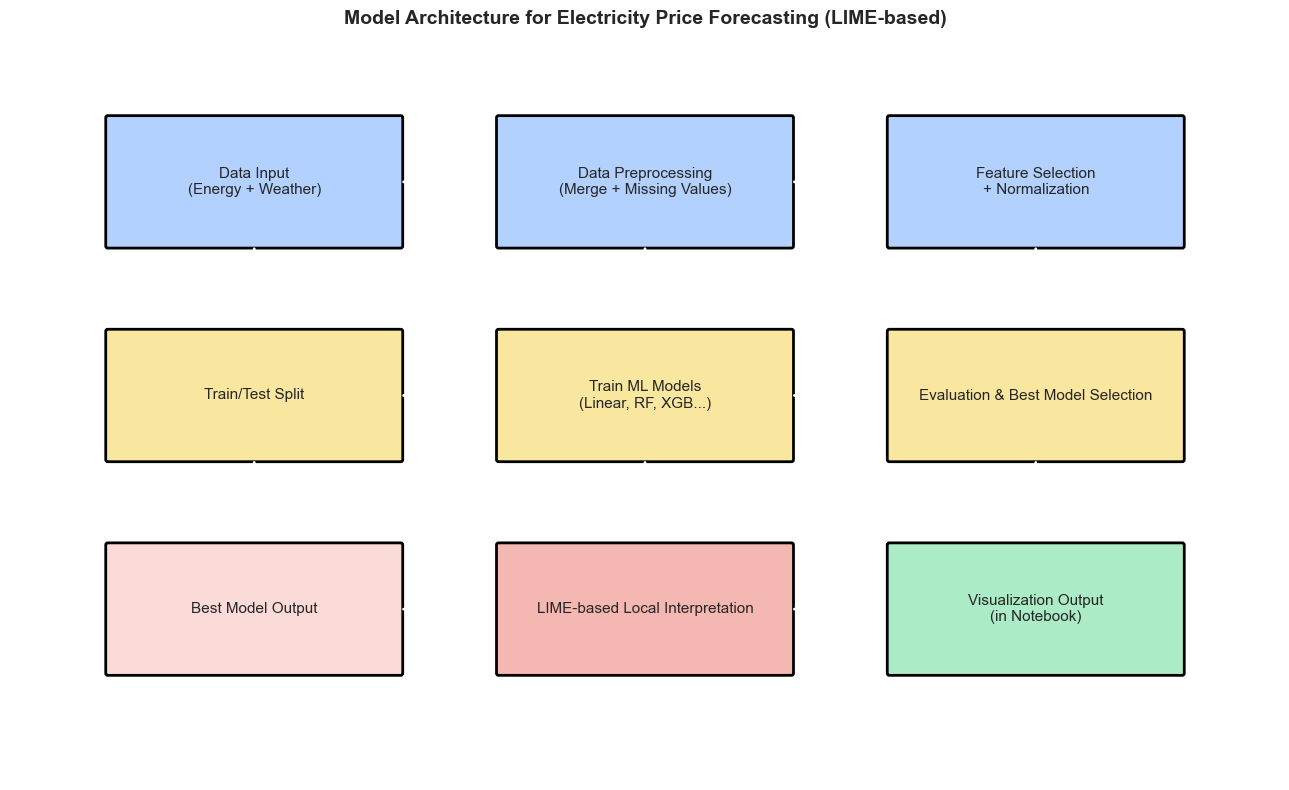

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(13, 8))

# Function to draw labeled boxes
def draw_box(x, y, text, color="#AED6F1", width=3, height=1.2):
    rect = patches.FancyBboxPatch(
        (x, y), width, height,
        boxstyle="round,pad=0.02",
        edgecolor="black",
        facecolor=color,
        linewidth=2
    )
    ax.add_patch(rect)
    ax.text(x + width/2, y + height/2, text, ha="center", va="center", fontsize=11)

# Boxes for each step
draw_box(0, 6, "Data Input\n(Energy + Weather)", "#B3D1FF")
draw_box(4, 6, "Data Preprocessing\n(Merge + Missing Values)", "#B3D1FF")
draw_box(8, 6, "Feature Selection\n+ Normalization", "#B3D1FF")

draw_box(0, 4, "Train/Test Split", "#F9E79F")
draw_box(4, 4, "Train ML Models\n(Linear, RF, XGB...)", "#F9E79F")
draw_box(8, 4, "Evaluation & Best Model Selection", "#F9E79F")

draw_box(0, 2, "Best Model Output", "#FADBD8")
draw_box(4, 2, "LIME-based Local Interpretation", "#F5B7B1")
draw_box(8, 2, "Visualization Output\n(in Notebook)", "#ABEBC6")

# Function to draw arrows between steps
def arrow(start, end):
    ax.annotate('', xy=end, xytext=start,
                arrowprops=dict(arrowstyle='->', lw=2))

# Horizontal arrows
arrow((3, 6.6), (4, 6.6))
arrow((7, 6.6), (8, 6.6))
arrow((3, 4.6), (4, 4.6))
arrow((7, 4.6), (8, 4.6))
arrow((3, 2.6), (4, 2.6))
arrow((7, 2.6), (8, 2.6))

# Vertical arrows
arrow((1.5, 6), (1.5, 5.2))
arrow((5.5, 6), (5.5, 5.2))
arrow((9.5, 6), (9.5, 5.2))
arrow((1.5, 4), (1.5, 3.2))
arrow((5.5, 4), (5.5, 3.2))
arrow((9.5, 4), (9.5, 3.2))

# Final layout settings
ax.set_xlim(-1, 12)
ax.set_ylim(1, 8)
ax.axis("off")
plt.title("Model Architecture for Electricity Price Forecasting (LIME-based)", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

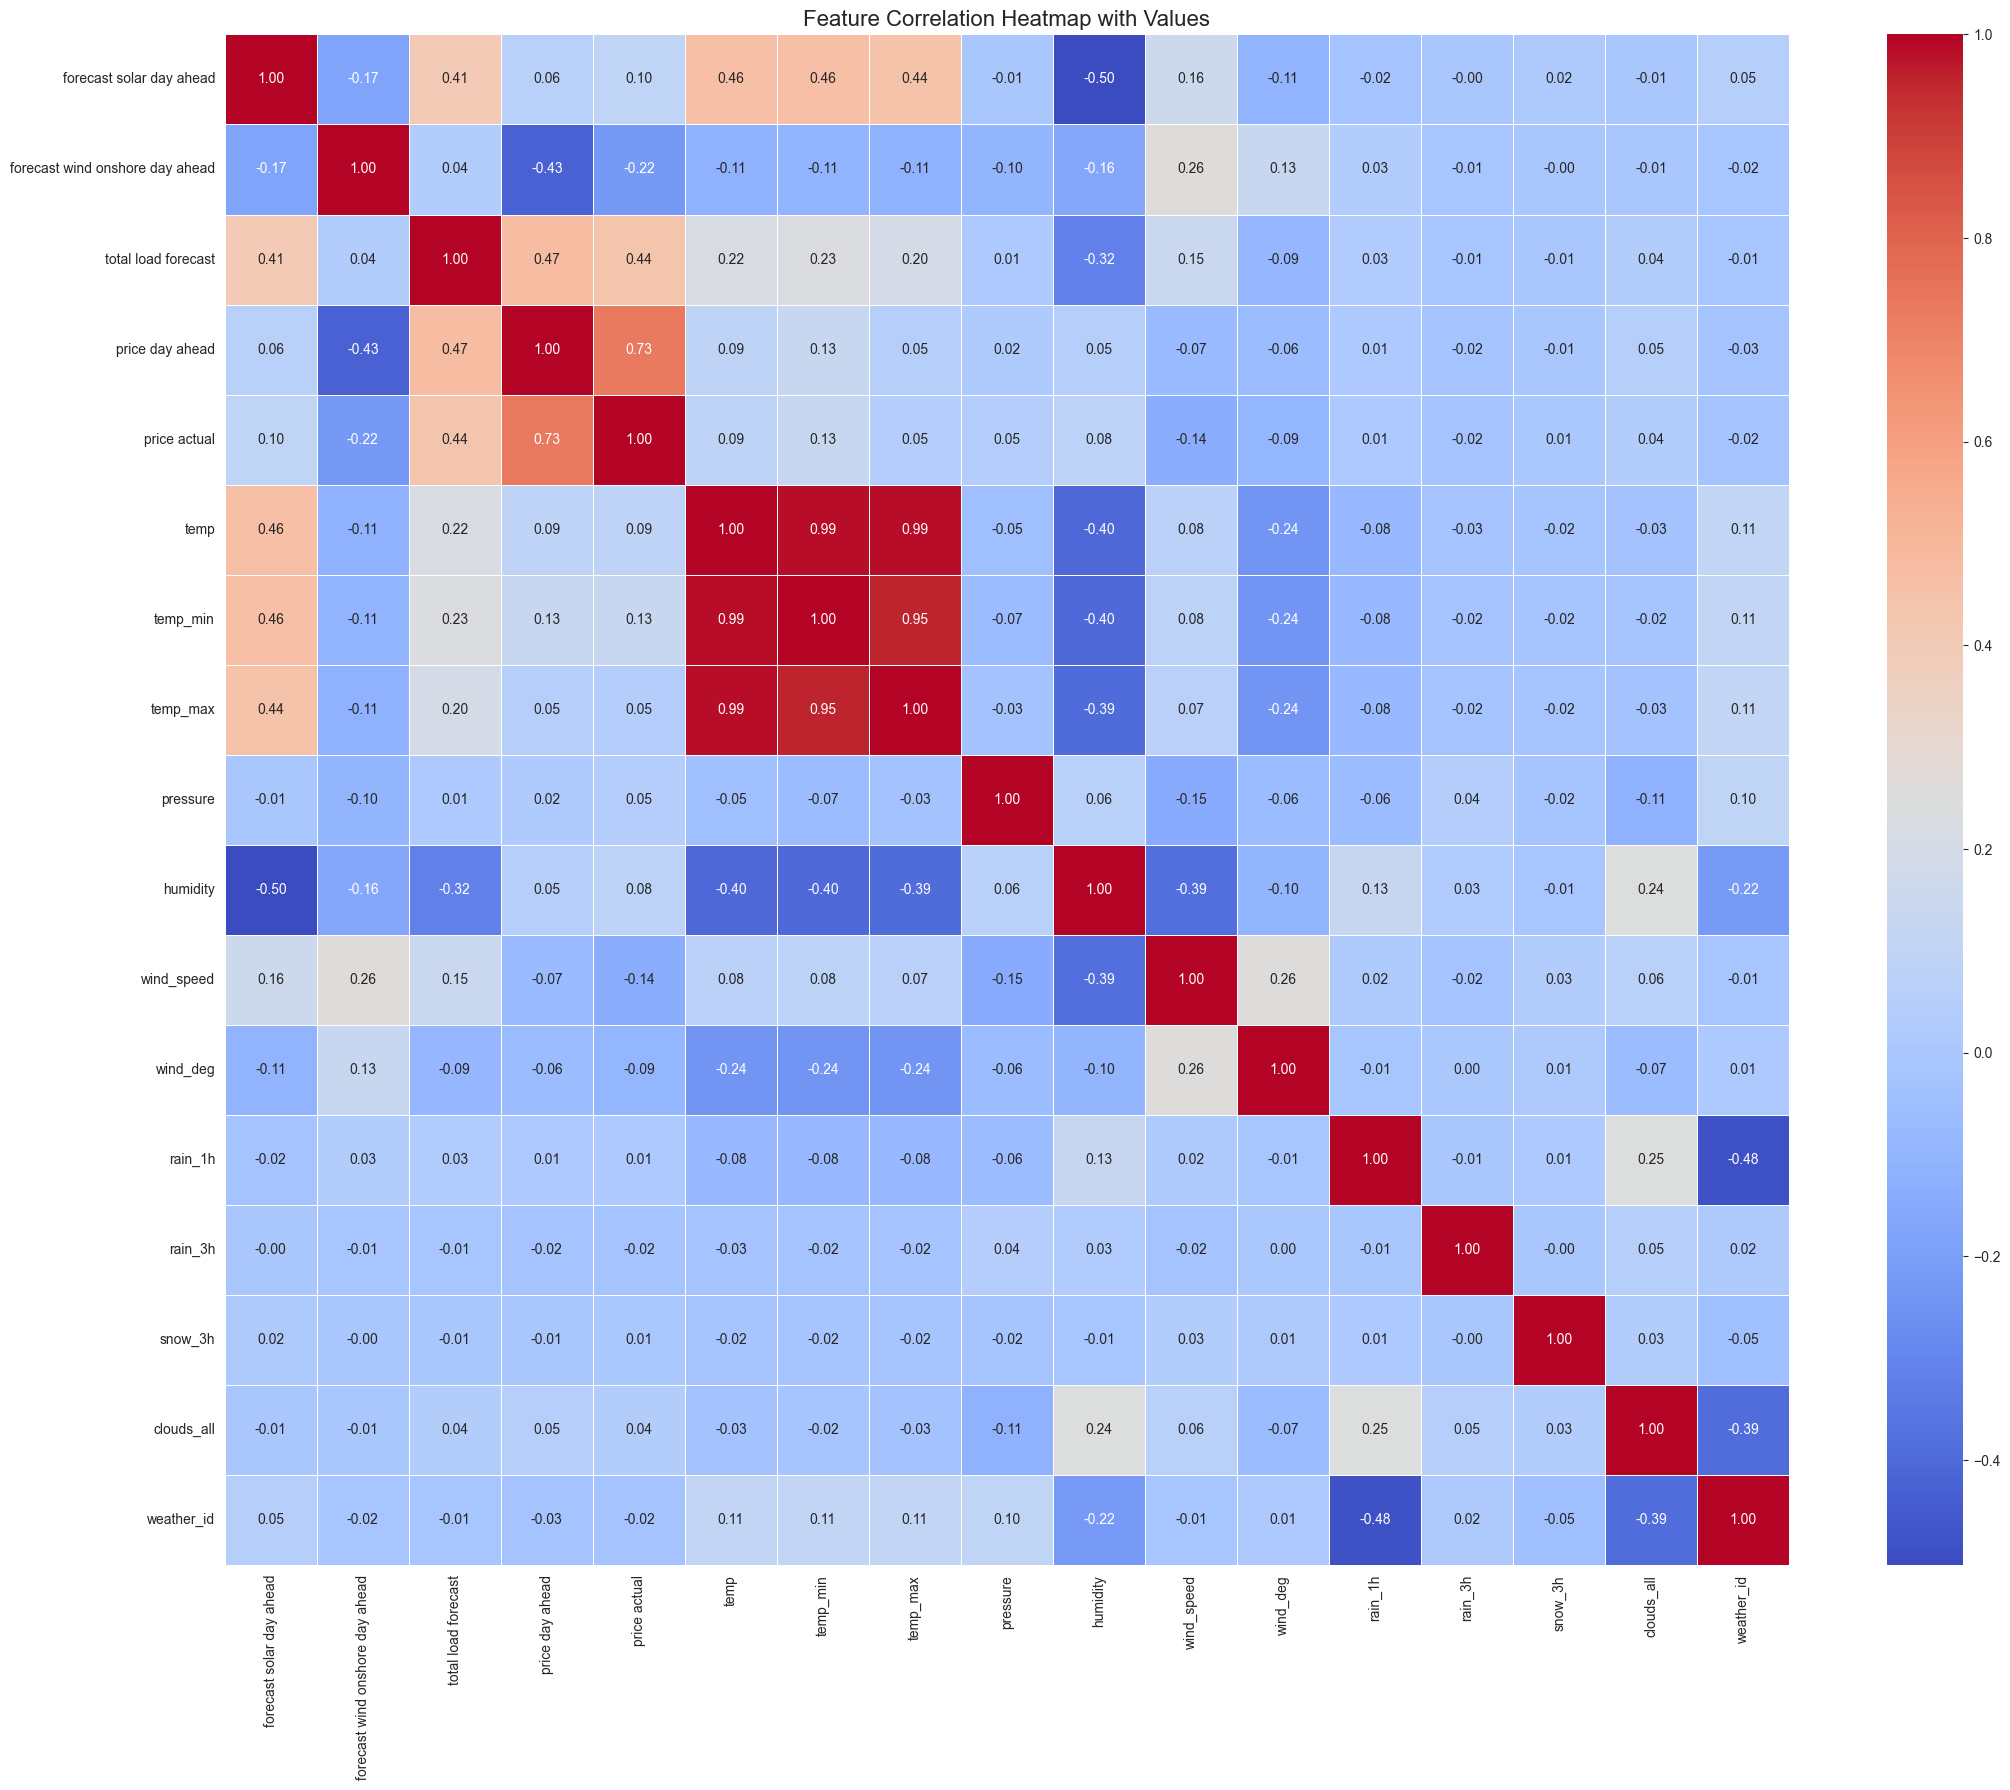

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
energy_df = pd.read_csv(r'D:\project1\pythonProject\ML-LIME-Power\dataset\energy_dataset.csv')
weather_df = pd.read_csv(r'D:\project1\pythonProject\ML-LIME-Power\dataset\weather_features.csv')

# Convert time columns to datetime format (use utc=True to suppress warnings)
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True)

# Filter for Valencia city and aggregate weather features
weather_valencia = weather_df[weather_df['city_name'] == 'Valencia'].copy()
weather_valencia.drop(columns=['city_name', 'weather_main', 'weather_description', 'weather_icon'], inplace=True)
weather_valencia = weather_valencia.groupby('dt_iso').mean().reset_index().rename(columns={'dt_iso': 'time'})

# Merge energy and weather data on the 'time' column
merged_df = pd.merge(energy_df, weather_valencia, on='time', how='inner')

# Keep only numeric columns without missing values
merged_df_numeric = merged_df.select_dtypes(include=['number']).dropna(axis=1)

# Compute correlation matrix
corr = merged_df_numeric.corr()

# Plot heatmap with correlation values
plt.figure(figsize=(22, 18))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap with Values', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [6]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import numpy as np

# 1. Feature selection + drop time column
X = merged_df.drop(columns=['price actual', 'price day ahead', 'time'])

# 2. Remove all-null columns + fill remaining missing values with median
X = X.dropna(axis=1, how='all')        # Drop columns that are entirely null
X = X.fillna(X.median())               # Fill other missing values with median

# 3. Define target variable
y = merged_df['price actual']

# 4. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Define a list of regression models
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "DecisionTree": DecisionTreeRegressor(),
    "KNN": KNeighborsRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor()
}
from sklearn.metrics import root_mean_squared_error
# 7. Evaluation function (includes 6 metrics)
def evaluate_model(name, model, X_test, y_test, y_pred):
    print(f"📌 {name}")
    print(f"  MAE:  {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"  MSE:  {mean_squared_error(y_test, y_pred):.3f}")
    print(f"  RMSE: {root_mean_squared_error(y_test, y_pred):.3f}")
    print(f"  R2:   {r2_score(y_test, y_pred):.3f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_test, y_pred):.3f}")
    print(f"  EVS:  {explained_variance_score(y_test, y_pred):.3f}")
    print("-" * 40)

# 8. Train and evaluate all models, select the best one based on R²
best_model = None
best_r2 = -np.inf

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    evaluate_model(name, model, X_test_scaled, y_test, y_pred)
    
    r2 = r2_score(y_test, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_model_name = name

print(f"✅ Best model: {best_model_name} (R² = {best_r2:.3f})")


📌 Linear
  MAE:  8.199
  MSE:  115.377
  RMSE: 10.741
  R2:   0.432
  MAPE: 0.172
  EVS:  0.432
----------------------------------------
📌 Ridge
  MAE:  8.199
  MSE:  115.376
  RMSE: 10.741
  R2:   0.432
  MAPE: 0.172
  EVS:  0.432
----------------------------------------
📌 DecisionTree
  MAE:  5.155
  MSE:  73.156
  RMSE: 8.553
  R2:   0.640
  MAPE: 0.101
  EVS:  0.640
----------------------------------------
📌 KNN
  MAE:  3.556
  MSE:  27.459
  RMSE: 5.240
  R2:   0.865
  MAPE: 0.069
  EVS:  0.865
----------------------------------------
📌 RandomForest
  MAE:  3.614
  MSE:  28.650
  RMSE: 5.353
  R2:   0.859
  MAPE: 0.074
  EVS:  0.859
----------------------------------------
📌 GradientBoosting
  MAE:  6.707
  MSE:  79.219
  RMSE: 8.901
  R2:   0.610
  MAPE: 0.140
  EVS:  0.610
----------------------------------------
📌 SVR
  MAE:  5.963
  MSE:  72.514
  RMSE: 8.516
  R2:   0.643
  MAPE: 0.126
  EVS:  0.643
----------------------------------------
📌 XGBoost
  MAE:  4.272
  MSE:  33.4

In [8]:
import lime
import lime.lime_tabular
import numpy as np

# 1. Create a LIME explainer (for regression tasks)
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns.tolist(),
    mode='regression',
    verbose=True,
    random_state=42
)

# 2. Randomly select one test sample (you can also set index i manually)
i = np.random.randint(0, X_test_scaled.shape[0])
sample = X_test_scaled[i].reshape(1, -1)

# 3. Generate LIME explanation for the selected instance
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_scaled[i],
    predict_fn=best_model.predict
)

# 4. Display the explanation in a notebook (visual + table)
lime_exp.show_in_notebook(show_table=True, show_all=False)


Intercept 53.25543855049878
Prediction_local [50.9389154]
Right: 55.562


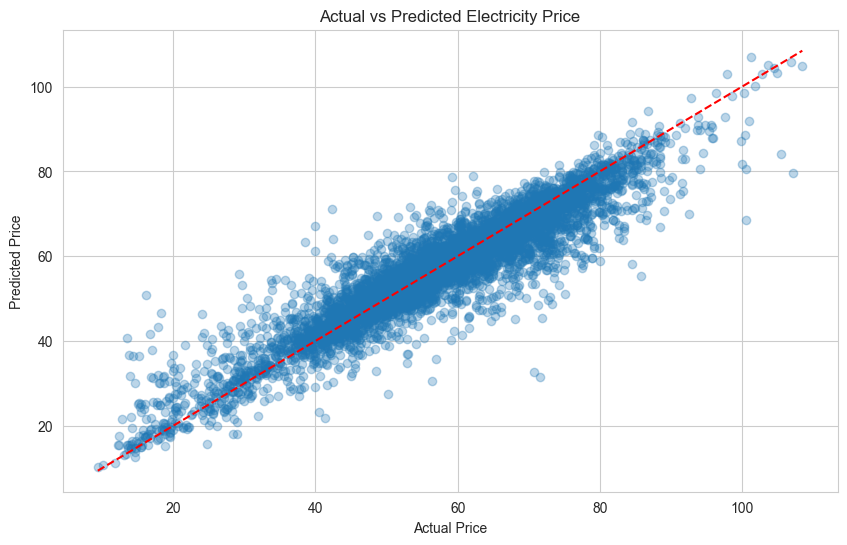

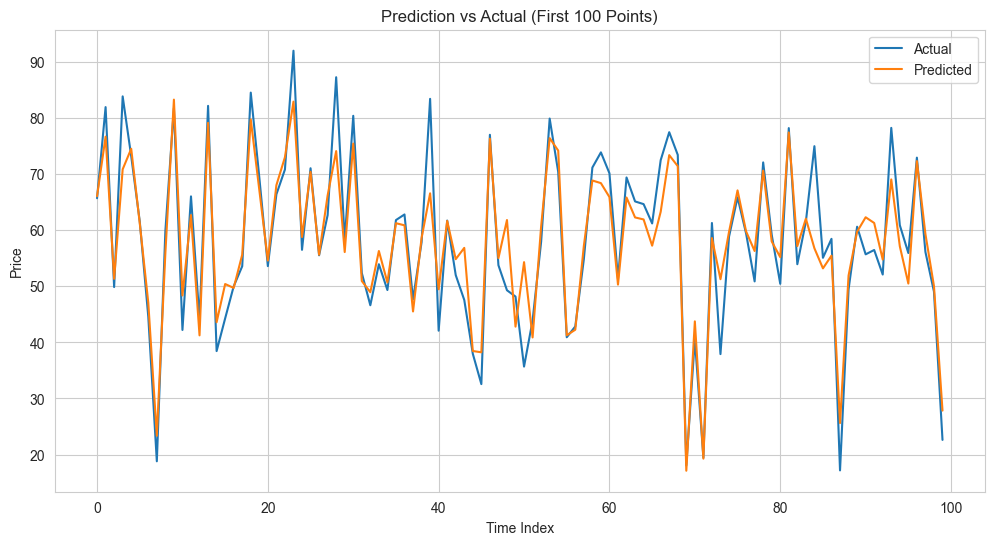

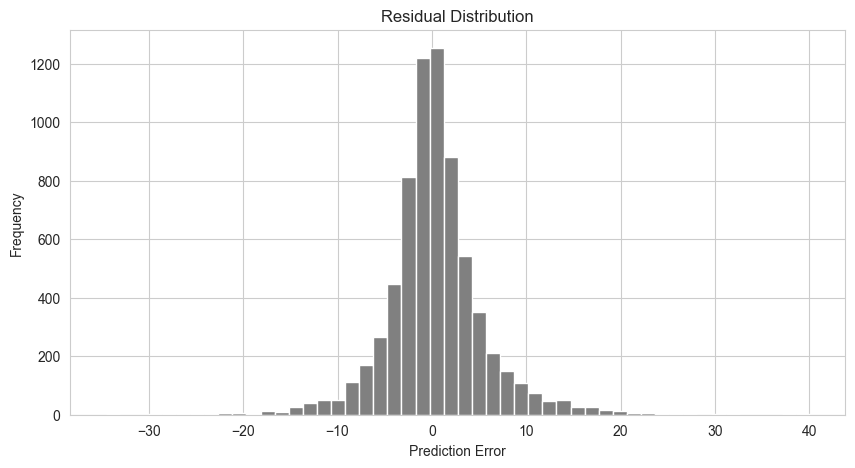

In [9]:
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test_scaled)

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Electricity Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Line Plot: Time Series (First 100 points)
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label="Actual")
plt.plot(y_pred[:100], label="Predicted")
plt.title("Prediction vs Actual (First 100 Points)")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot: Distribution of Prediction Errors
residuals = y_test - y_pred
plt.figure(figsize=(10,5))
plt.hist(residuals, bins=50, color='gray')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()
